# Nudge Your Run Pace with Music
> Let music help guide your pace!

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

## You Create a Custom Playlist for Your Races?

<img src="../images/napa_half.jpg" style="float:left;width:400px; height:500px;">
<br clear="all" />

The year was 2009. I was training for the Chicago Half Marathon and it was still the era of having music take up physical space on your device. I would spend a good chunk of time loading up my phone with the most blood-pumping, angriest, high-energy songs I knew for my training runs. The thought was that I needed every ounce of help I could get to get through my first race longer than 10k.  

A decade and a few more long distance races under my belt later, I was still at it but apps like Pandora and Spotify had changed the game when it came to music and running, or any physical activity for that matter. I had turned coordinating music with my runs it into a bit of an art. I would estimate what my pace would be, look at the course profile to figure out sections where I thought I might need a morale boost, and cater the playlist accordingly.

#### I Don't Have Time for That

Oh for sure! Neither should I. Which is why I set out to come up with a program that automates it. What if based on a route profile, I had something that could:  

- predict when and where I might go too fast or too slow
- motivate me so that I'm putting in the right amount of effort for my pace
- acheive the former through music  

And so my final project idea was born.

## My Data, literally

The data I would use is my own. In total about 100 runs totaling around 600 miles over the last 12 months, for which my Garmin recorded data about every 3-4 seconds of each run. If I didn't have a deadline, I could've spent days looking at different trends and metrics. 

The best part? If I wanted to test something out and get more data, I just laced on my shoes and went for a run: music, no music, dry podcasts, lots of little hills, one big hill, etc. There were a lot of variables to tweak.

In [137]:
#collapse-hide
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("dark")

# DF to graph raw Strava data from API
raw_df = pd.read_csv('activity_list.csv', index_col=0)
df = raw_df.drop('athlete', axis=1)
df['dt_date'] = pd.to_datetime(df['start_date'])
df['dt_date'] = df['dt_date'].apply(lambda x: x.replace(tzinfo=None))
current = datetime.now()
# Filtering data to just the last 12 months
ltm_df = df[df['dt_date'] > current - timedelta(days=382)]

In [138]:
#collapse-hide
run_count = ltm_df.groupby(pd.Grouper(key='dt_date', freq='1M'))['distance'].count()
run_dist = ltm_df.groupby(pd.Grouper(key='dt_date', freq='1M'))['distance'].sum()

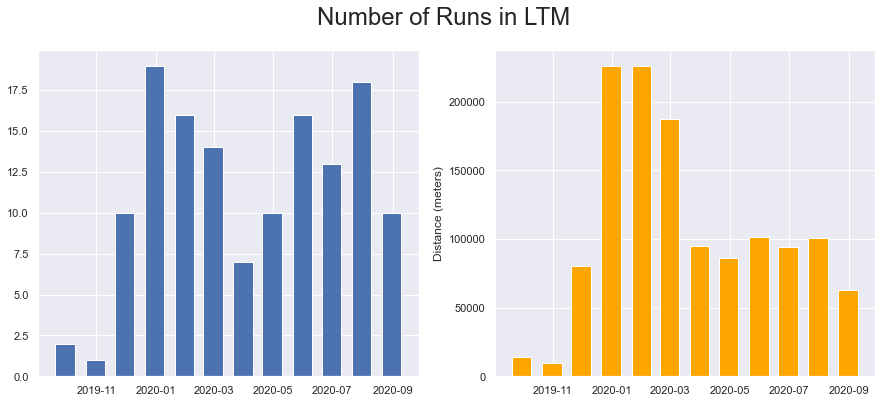

In [142]:
#collapse-hide
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Number of Runs in LTM', fontsize=24)
ax1.bar(run_count.index, run_count, width=20)

ax2.bar(run_count.index, run_dist, width=20, color='orange')
ax2.set_ylabel('Distance (meters)')
plt.show()

## A time-series problem, sort of

Once I got all the data in the form I wanted, which included:

- Extracting GPS data
- Calculating different distances and elevation change between segments
- Getting all data measured in the same time increments (my Garmin device takes measurements at random times)

I used it as follows:

![](../images/Overview.png)

1) Data was fed to 2 time-series models, one to predict pace and another to predict cadence for the next 30 second segment.  
2) Based on the predicted pace and how it compares to a runner's baseline pace, a decision is made as to whether to keep the music at the same bpm that corresponds to the current cadence or adjust the tempo of the music to signal that either the runner should slow down or increase effort.  
3) Depending on the decision, the program communicates with the Spotify API program to queue up songs and change  songs on the user's device, if necessary.

![](../images/Tableau.png)

I created a dashboard that shows a runner's progress and their actual vs. predicted cadence and pace to go along with a script that simulates the music changing as the run progresses. I'll update the articel with the link when the video is up.

## My Gripe

The biggest issue I have right now is that **I have to create a new model for every run.** Actually, that's putting it lightly; my current algorithm creates a new model every 30 seconds.

![](../images/Model_Training.png)

The first model trains for a little longer and no predictions are made for the first 3 minutes because predictions are pretty inaccurate before the model sees a certain amount of data beforehand. After the first model makes its prediction, it's tossed and a new one is made using the initial training data, plus the real-time data coming in for the segment for which the prediction was made. This newly trained model makes the prediction for the next time interval. This cycle continues until the end of the run.  

**My next question was:** How can I leverage my data across multiple runs so that I don't have to train a model for as long in the beginning? Further, how can I use the variables across different runs to make better forecasts? Ambient temperature is one of the primary factors because there's nothing more grueling that going on a run in 90 degree weather. 

It turns out this is a lot harder than anticipated so I'm saving it for the next phase (Sequence-to-Sequence Modeling of Time Series): https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/

## Other Add Ons

When I was testing this on myself, it wasn't only the tempo of the music that changed my effort. Different audio features and genre of music also affected my effort and I'm speculating these different audio features affect different runners in different ways. I smell an unsupervised, clustering problem in the future.

I also want to throw in heart rate predictions to see if I can create a feature to use music to keep a person in specific cardio zones. 

Thanks for reading! Hit me up if you want to talk running, data, or both!